In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from scipy import stats

from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The original dataset was saved in ./dataset folder of the repository.
Following code will read it, split and save into the full_train part for training and validating purposes and the test part

In [2]:
data = pd.read_csv("./dataset/car_prices.csv", sep=",", on_bad_lines='skip')

data_full_train, data_test = train_test_split(data, test_size=0.2, random_state=9)

data_full_train.to_csv("./dataset/car_prices_full_train.csv", index=False)
data_test.to_csv("./dataset/car_prices_test.csv", index=False)

In [3]:
def dataset_cleaning(df):
    """
    pd.DataFrame -> pd.DataFrame
    Initial cleaning of the data:
     - lower case converting
     - replacing spaces with "_"
     - datetime format transformation
    """
    
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    df.saledate = pd.to_datetime(df.saledate)

    categorical_cols = df.select_dtypes(["object"]).columns.to_list()
    categorical_cols.remove("saledate")

    for col in categorical_cols:
        df[col] = df[col].str.lower().str.replace(" ", "_")
    
    return df

Reading full_train dataset

In [4]:
df = pd.read_csv("./dataset/car_prices_full_train.csv", sep=",", on_bad_lines='skip')
df = dataset_cleaning(df)

df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2012,mercedes-benz,gl-class,gl450_4matic,suv,automatic,4jgbf7be1ca781842,nv,2.6,62622.0,black,black,the_hertz_corporation,25900,24800,2015-01-09 12:00:00+08:00
1,2012,honda,pilot,ex-l,suv,automatic,5fnyf4h74cb027511,tn,2.6,33268.0,gray,black,eurofix,24100,26000,2015-02-11 02:30:00+08:00
2,2012,hyundai,sonata,se,sedan,NaN,5npec4ab9ch415040,pa,1.9,19270.0,white,black,hyundai_motor_finance,14750,13000,2015-02-27 01:00:00+08:00
3,2013,infiniti,g_sedan,g37_journey,g_sedan,automatic,jn1cv6ap5dm720571,ca,4.9,15802.0,silver,black,nissan_infiniti_lt,23800,25000,2014-12-18 12:30:00+08:00
4,2013,volkswagen,passat,se_pzev,sedan,automatic,1vwbp7a3xdc111419,tx,4.4,56186.0,gray,black,hopper_motorplex_inc,10800,10900,2015-06-03 03:15:00+07:00


There are:
- 4 number columns - condition, odometer, mmr, sellingprice
- 10 categorical columns - make, model, trim, body, transmission, vin, state, color, interior, seller
- and 2 date columns - year, saledate

In [5]:
df.dtypes

year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
mmr               int64
sellingprice      int64
saledate         object
dtype: object

The following description table along with standart count, mean, min/max, std parameters represents quantile distribution of dataset mass.
The most interesting things:
- need to investigate values 1 and 999999 in 'odometer' feature
- need to investigate value 1 in 'sellingprice' column
- there is a big difference between 99.5 quntile and max value for 'odometer', 'mmr' and 'sellingprice' looks like its need to use log-transformation for them

In [6]:
df.describe(percentiles=[0.05, 0.50, 0.99, 0.995])

,year,condition,odometer,mmr,sellingprice
count,447048.000000,437745.000000,446975.000000,447048.000000,447048.00000
mean,2010.036065,3.423992,68324.364320,13764.158826,13604.35519
std,3.968462,0.949047,53216.639826,9685.817507,9746.97654
min,1982.000000,1.000000,1.000000,25.000000,1.00000
5%,2002.000000,1.900000,10519.700000,1800.000000,1500.00000
50%,2012.000000,3.600000,52294.000000,12250.000000,12100.00000
99%,2015.000000,5.000000,226699.260000,44800.000000,44750.00000
99.5%,2015.000000,5.000000,250951.390000,52700.000000,52750.00000
max,2015.000000,5.000000,999999.000000,182000.000000,183000.00000


In [7]:
# Checking the numbers of unique values for categorical columns

cat_features = [
    "make",
    "model",
    "trim",
    "body",
    "transmission",
    "vin",
    "state",
    "color",
    "interior",
    "seller",
    ]

for col in df[cat_features]:
    print("%15s" %col, "%10s" %df[col].nunique())

           make         63
          model        839
           trim       1850
           body         44
   transmission          2
            vin     441621
          state         38
          color         20
       interior         17
         seller      13197


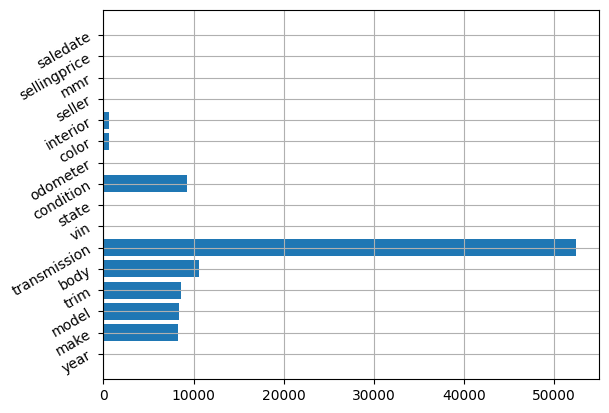

In [8]:
# Checking the number of missing values for each column

df_nulls = df.isnull().sum()

plt.barh(width=df_nulls.values, y = range(df_nulls.shape[0]))
plt.yticks(range(df_nulls.shape[0]), df_nulls.index, rotation=30)
plt.grid()
plt.show()


### Exploratory data analysis

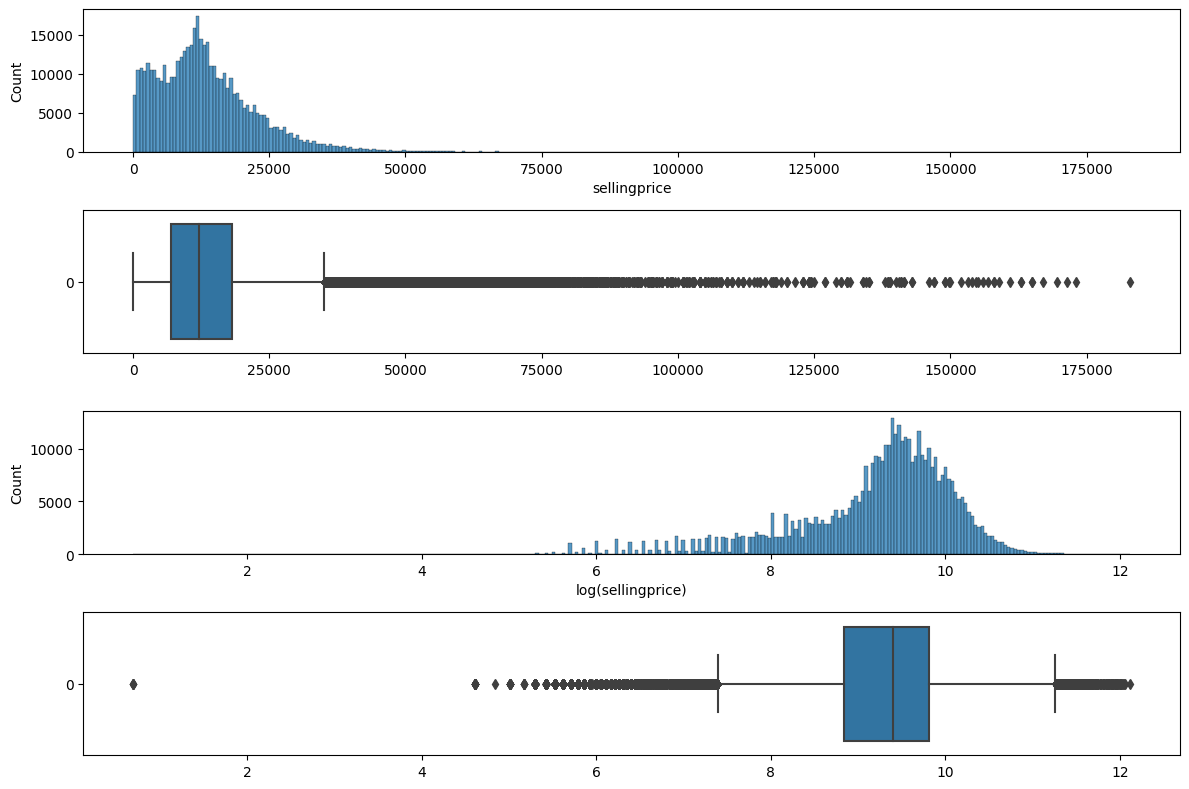

In [9]:
# sellingprice and log(sellingprice)

fig, axes = plt.subplots(4,1, figsize=(12,8))
sns.histplot(df.sellingprice, bins=300, ax=axes[0])
sns.boxplot(df.sellingprice, orient='horizontal', ax=axes[1])

sns.histplot(np.log1p(df.sellingprice), bins=300, thresh=0.5, ax=axes[2])
sns.boxplot(np.log1p(df.sellingprice), orient='horizontal', ax=axes[3])
axes[2].set_xlabel("log(sellingprice)")

plt.tight_layout()
plt.show()

In [10]:
# Checking the number of min 'sellingprice' values. There is a record of almost new cars and good contidion. Looks like its outliers.
# It is better to filter data for model not to train on them.

display(df[df.sellingprice == min(df.sellingprice)])

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
36977,1995,isuzu,rodeo,ls,suv,NaN,4s2cm58v9s4375559,va,1.0,254132.0,red,gray,automotive_remarketing_inc,375,1,2015-03-04 01:05:00+08:00
60195,2003,mercedes-benz,e-class,e500,sedan,automatic,wdbuf70j73a269529,ga,2.1,1.0,black,black,peoples_credit_company_inc,7325,1,2015-01-06 09:30:00+08:00
126491,2014,ford,e-series_van,e-250,e-series_van,automatic,1ftne2ew6eda13643,tx,4.1,31886.0,white,gray,u-haul,20800,1,2015-02-12 03:00:00+08:00
280197,2002,ford,f-350_super_duty,xlt,crew_cab,NaN,1ftsw31f52ed16477,ca,2.0,NaN,white,gray,laa_leasing,7850,1,2015-02-05 04:00:00+08:00


In [11]:
# Investigating max value of 'sellingprice' Its OK.

display(df[df.sellingprice == max(df.sellingprice)])

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
379179,2011,ferrari,458_italia,base,coupe,automatic,zff67nfa1b0178698,fl,4.6,12116.0,red,black,platinum_motor_cars,182000,183000,2015-06-17 03:40:00+07:00


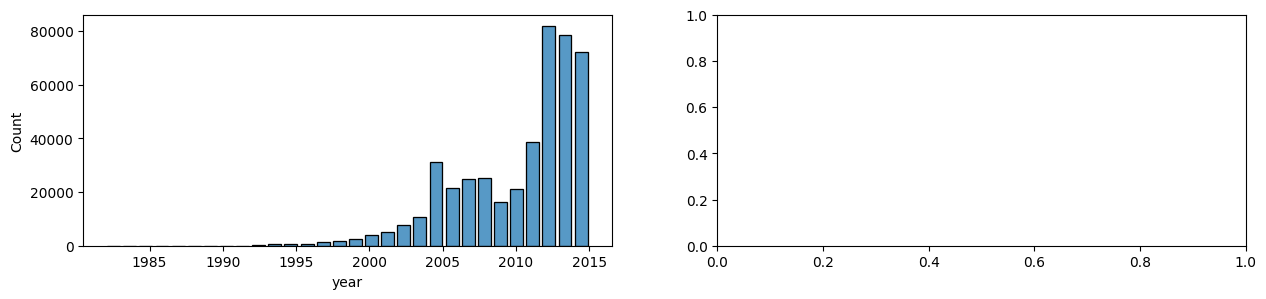

In [12]:
# Distriburion of year feature

sns.histplot(df.year, ax=axes[0], shrink=0.8, bins=30)
plt.show()

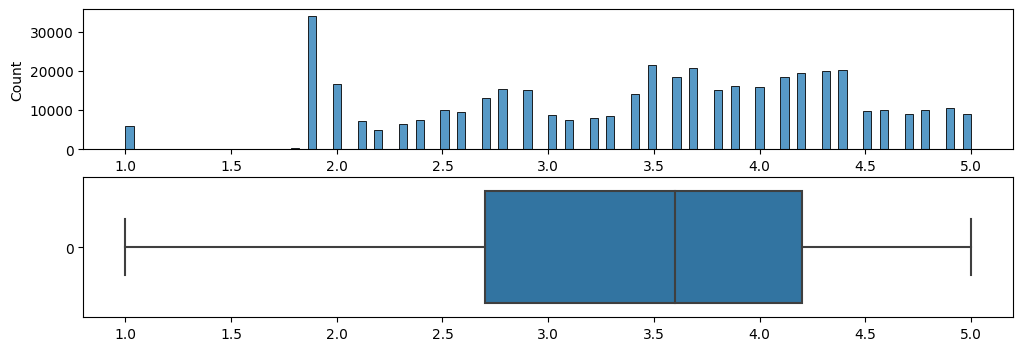

In [13]:
# Distribution of condition feature

fig, axes = plt.subplots(2,1, figsize=(12,4))
sns.histplot(df.condition, ax=axes[0])
sns.boxplot(df.condition, ax=axes[1], orient='horizontal')
plt.show()

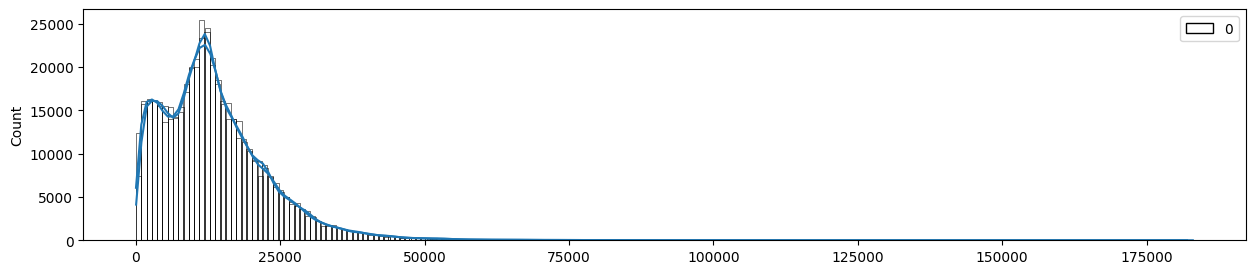

In [14]:
# mmr and sellingprice features almost completly correspond.
# mmr is a Manhiem market record, the market estimated price of the cars and its is highly correlated with final price.
# Better to drop this feature becuse the model can simpy use it to make a prediction that can lead to overfitting

plt.figure(figsize=(15,3))
sns.histplot(df["mmr"].values.reshape([-1,1]), bins=200, alpha=0.2, color='b', facecolor='none', kde=True)
sns.histplot(df["sellingprice"].values.reshape([-1,1]), bins=200, alpha=0.3, color='g', facecolor='none', kde=True)

plt.show()


Min odometer value 1.0
Second min odometer value 2.0
Max odometer value 999999.0
Second max odometer value 959276.0


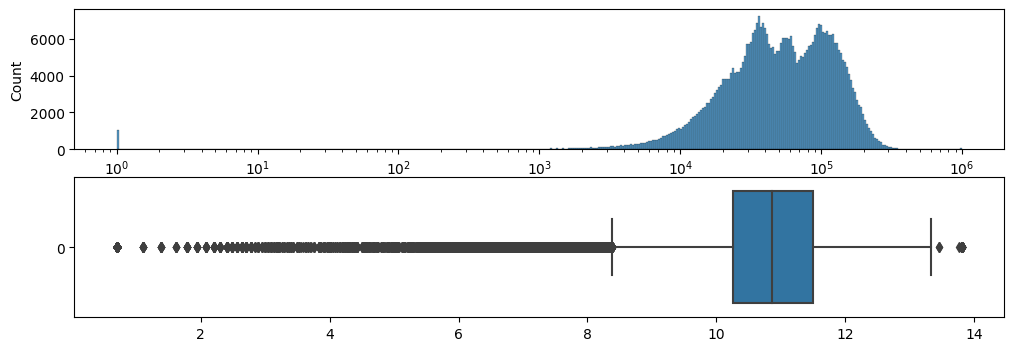

In [15]:
# Incvestigating min, max, second min and second max and distribution for odometer
# Its need to use log-transformation
# As soon as min and second min, max  and second max values are close no need to filter this feature

min_odometer = min(df.odometer)
next_min = min(list(filter(lambda x: x > min_odometer, df.odometer)))
print(f"Min odometer value {min_odometer}")
print(f"Second min odometer value {next_min}")

max_odometer = max(df.odometer)
next_max = max(list(filter(lambda x: x < max_odometer, df.odometer)))
print(f"Max odometer value {max_odometer}")
print(f"Second max odometer value {next_max}")

fig, axes = plt.subplots(2,1, figsize=(12,4))
sns.histplot(df.odometer, ax=axes[0], log_scale=True)
sns.boxplot(np.log1p(df.odometer), ax=axes[1], orient='horizontal')
plt.show()

/tmp/ipykernel_9141/3297891483.py:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(column=num_columns, bins=200, layout=(2,3), ax=ax)


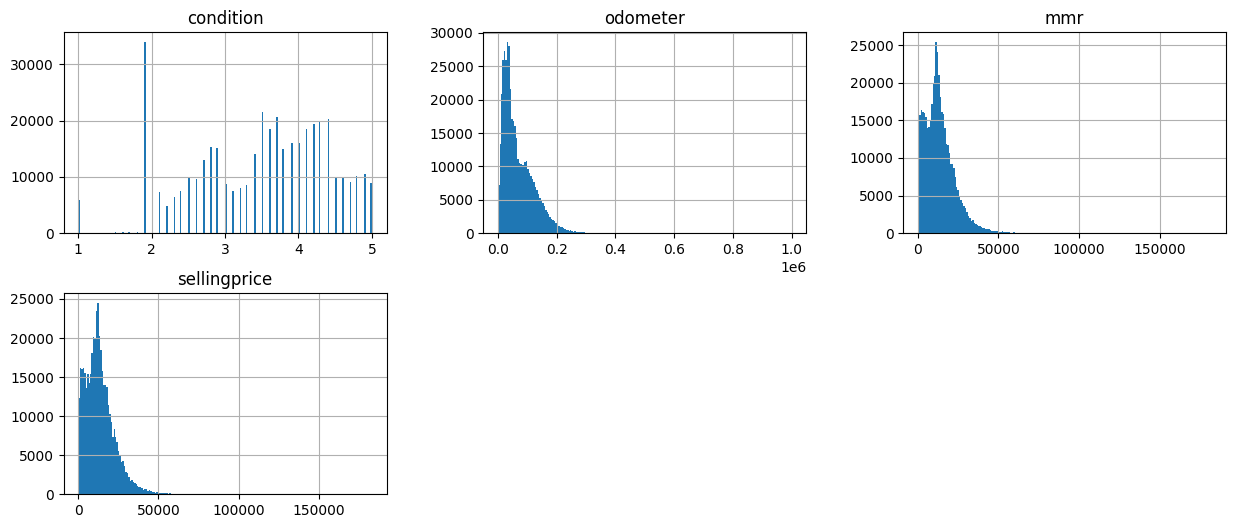

In [16]:
num_columns = [
    "condition",
    "odometer",
    "mmr",
    "sellingprice",
]

plt.figure(figsize=(15,6))
ax = plt.gca()
df.hist(column=num_columns, bins=200, layout=(2,3), ax=ax)
plt.xscale("log")
plt.show()

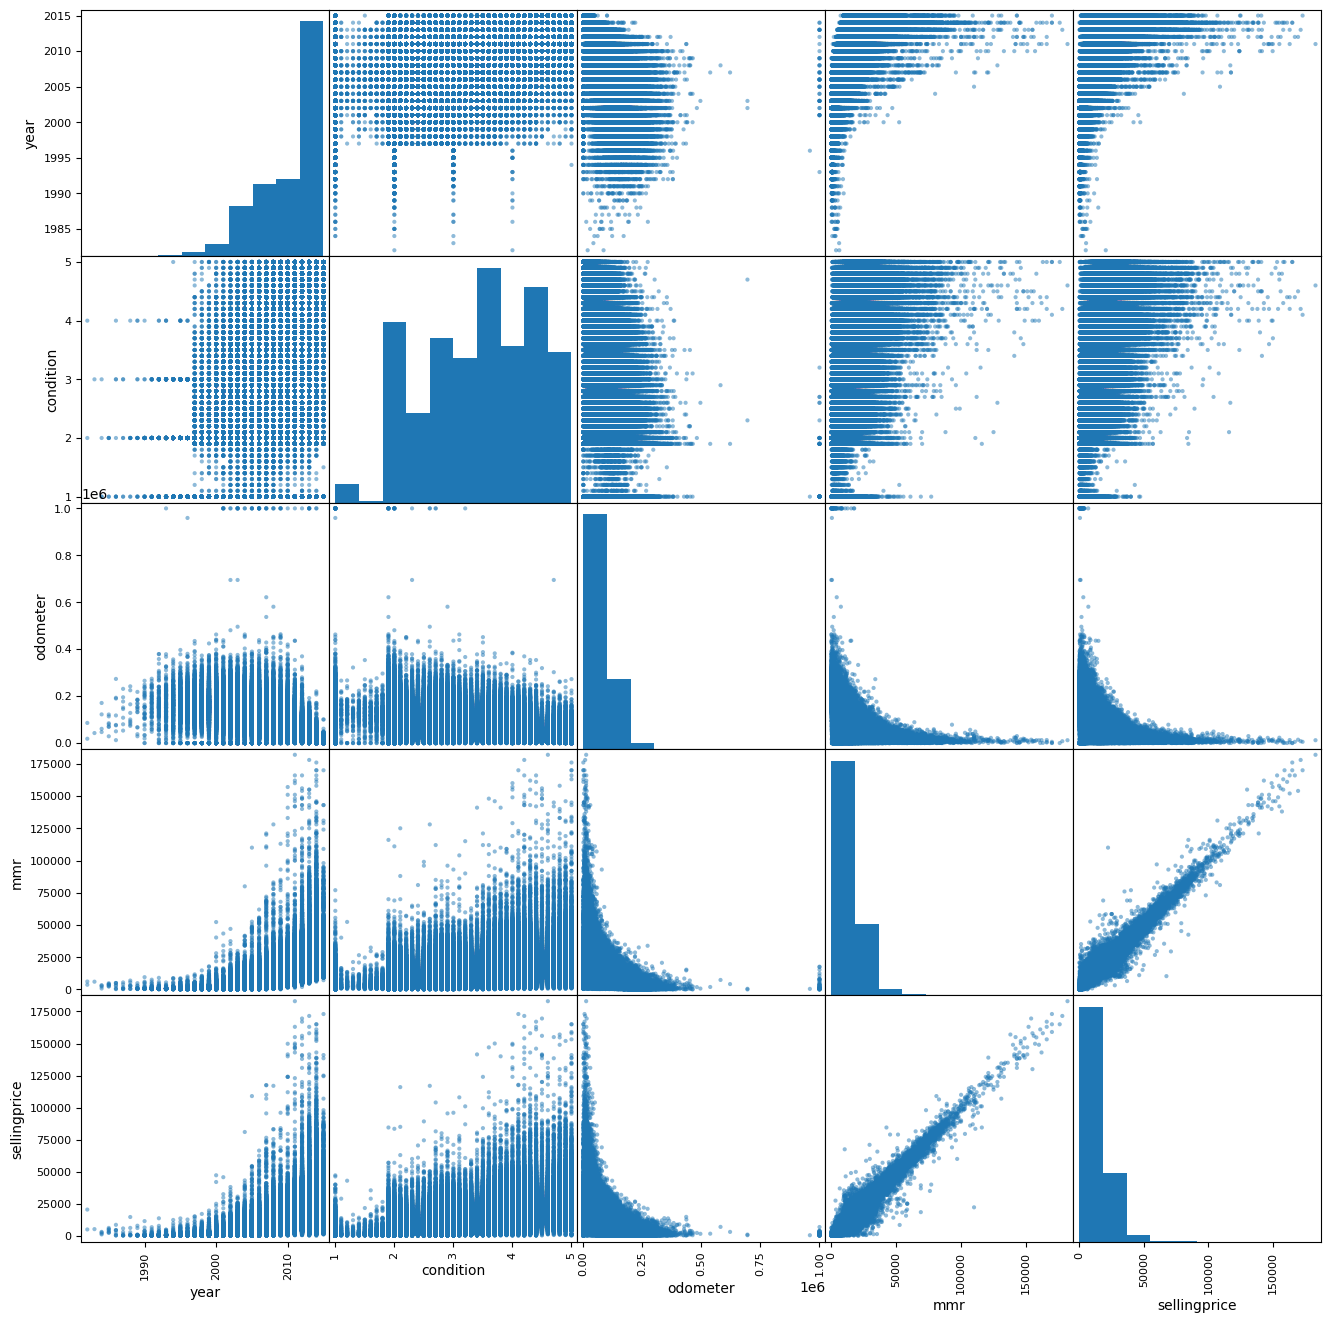

In [17]:
# Scatter matrix for numerical features

pd.plotting.scatter_matrix(df, figsize=(16,16))
plt.show()

Features importance

In [18]:
features = [
    "year",
    "make",
    "model",
    "trim",
    "body",
    "transmission",
    "state",
    "condition",
    "odometer",
    "mmr",
    "color",
    "interior",
    "seller",
    "sellingprice"
]

numeric_features = [
    'year',
    'condition',
    'odometer',
    'mmr'
    ]

additional_features = [
    'age',
    'noise',
    'reversed_odometer'
    ]

df_plus_features = df[features].dropna().copy()
df_plus_features["age"] = max(df_plus_features.year) - df_plus_features.year
df_plus_features["reversed_odometer"] = 1. / df_plus_features.odometer

In [19]:
# Lets add a random noise feature to out dataset

rnd = np.random.RandomState(5)

size = len(df_plus_features)

df_plus_features["noise"] = rnd.random(size=size)

In [20]:
# Mutual information scores for categorical features - looks like we can drop 'interior', 'color', 'transmission' features

mi_score_cat = pd.Series(dtype="float")
cat_features = list(df_plus_features.select_dtypes("object").columns)

for col in df_plus_features[cat_features]:
    mi_score_cat.loc[col] = mutual_info_score(df_plus_features[col], df_plus_features["sellingprice"])

mi_score_cat.sort_values(ascending=False)

seller          1.401402
model           0.843560
trim            0.758266
make            0.244751
body            0.163685
state           0.137631
interior        0.062221
color           0.056911
transmission    0.005074
dtype: float64

In [21]:
# Mutual information scores for numerical features.
# All of them are significantly higher than noise feature. Our model should use all but mmr as has been sad earlier

mi_score_num = pd.Series(mutual_info_regression(df_plus_features[numeric_features + additional_features],
                                                df_plus_features["sellingprice"]
                                                ),
                        index = numeric_features + additional_features)

mi_score_num.sort_values(ascending=False)

mmr                  1.789935
year                 0.443645
age                  0.442490
reversed_odometer    0.419314
odometer             0.419086
condition            0.267990
noise                0.001448
dtype: float64

In [22]:
# Pearson correlation between numerical features and sellingprice

df_plus_features[numeric_features + additional_features].corrwith(df_plus_features["sellingprice"], method='pearson').sort_values(ascending=False)

mmr                  0.984082
year                 0.579129
condition            0.536333
noise               -0.000593
reversed_odometer   -0.051862
age                 -0.579129
odometer            -0.579783
dtype: float64

In [23]:
# Investigation of prices and number of unique cars of different body-types across different makers

agg_funcs = ["mean", "median", "min", "max", "nunique"]

for make in df.make.unique():
    mask = df.make == make
        
    print(f"{make}")
    display(df[mask].groupby(by=["body"]).agg({"sellingprice": agg_funcs}).round(1))

mercedes-benz


sellingprice                                
                    mean   median    min     max nunique
body                                                    
convertible      23855.3  18700.0    350  127000     424
coupe            22531.6  23500.0    700  124500     299
hatchback         4163.5   2450.0    575   28750      36
sedan            20601.1  20400.0      1  173000     692
suv              24823.0  24000.0    300  141000     630
van              24507.0  25250.0  10600   39500      49
wagon             9630.8   8000.0    350   49500     176

honda


sellingprice                              
                    mean   median   min    max nunique
body                                                  
convertible      12646.9  12700.0  3300  27800      32
coupe             7689.8   6900.0   200  27750     278
crew_cab         17326.8  16150.0  4650  33000     123
hatchback        11609.7  11100.0   300  27750     233
minivan          12203.5  10600.0   250  36250     403
sedan             9566.8  10700.0   200  27600     368
suv              14731.7  15500.0   300  37000     429
wagon              383.3    400.0   300    450       3

hyundai


sellingprice                              
                      mean   median   min    max nunique
body                                                    
elantra_coupe      12130.5  12000.0  2500  16300      40
genesis_coupe      15802.2  15400.0  1600  29400     121
hatchback           9454.8  10500.0   300  39500     220
minivan             4223.6   3700.0  1150  10500      39
sedan              11039.1  11400.0   100  55000     466
suv                11491.6  11000.0   300  36600     337
wagon               1162.5    950.0   250   2500       4

infiniti


sellingprice                               
                        mean   median    min    max nunique
body                                                       
convertible          18675.0  18275.0  14200  21900      14
coupe                 9058.5   8500.0   1300  19250     148
g37_convertible      19829.4  20000.0  13500  26200      14
g37_coupe            15477.3  15500.0  10900  19400      11
g_convertible        26477.8  26000.0  18250  38500      92
g_coupe              22466.7  22500.0  10250  44700     146
g_sedan              19981.6  20000.0   9500  44000     178
q60_convertible      36755.4  36500.0  31000  42200      29
q60_coupe            29593.3  29000.0  25200  38200      23
sedan                17080.6  20350.0    200  42800     406
suv                  25935.4  27500.0    350  75000     538

volkswagen


sellingprice                               
                           mean   median    min    max nunique
body                                                          
beetle_convertible      18434.8  18050.0  14500  24000      30
convertible              6967.3   5100.0    300  27800     166
hatchback                8684.4   8750.0    200  30100     273
minivan                  9574.9   9400.0   1800  20600     109
sedan                    9195.9   9900.0    200  31200     345
suv                     13851.9  13250.0    800  42800     272
wagon                    8167.7   7600.0    300  23750     177

cadillac


sellingprice                               
                    mean   median    min    max nunique
body                                                   
convertible      18510.0  19750.0    600  34500      19
coupe             5151.1   1350.0    325  44000      31
crew_cab         18791.9  18650.0   2400  43800     108
cts-v_coupe      37832.0  37500.0  30500  51250      24
cts_coupe        23003.0  22600.0  16200  35400      78
cts_wagon        16566.7  16725.0  11500  26000      11
sedan             9561.5   6600.0    200  46600     439
suv              21732.3  20900.0    250  83000     567

dodge


sellingprice                               
                     mean   median    min    max nunique
body                                                    
club_cab           4885.7   4450.0    400  12200      79
convertible       35775.0  34600.0  28700  43250       5
coupe             20352.4  19800.0    275  51700     297
crew_cab          19173.9  18500.0    800  41750     138
extended_cab       2712.3   1600.0    300  13700      33
mega_cab          19340.0  19450.0   7200  32250      41
minivan           11124.6  11200.0    200  30400     332
quad_cab          10413.0   9500.0    400  32000     317
ram_van            1200.0   1200.0   1200   1200       1
regular_cab        6041.2   5300.0    300  22000     121
sedan             10684.2  10200.0    200  40000     406
suv               12869.9  12000.0    100  43600     458
van                8035.2   7400.0    400  19300      71
wagon              4689.4   4200.0    300  19600     144

lexus


sellingprice                               
                    mean   median    min    max nunique
body                                                   
convertible      20920.0  22200.0   4700  40200     132
coupe            16178.1   2550.0    200  66500      23
hatchback        19809.5  19400.0  11600  33600     113
sedan            18386.8  19100.0    200  67000     585
suv              23661.2  26150.0   1200  79750     556
wagon             4500.0   3600.0   2900   8500       5

ford


sellingprice                               
                     mean   median    min    max nunique
body                                                    
convertible       13759.2  13600.0    400  59400     343
coupe             14326.1  14600.0    300  58600     438
crew_cab          22446.6  20800.0      1  58500     580
e-series_van      19139.1  20000.0      1  30800     198
extended_cab       1756.4   1500.0    300   8300      60
hatchback         10342.0  10600.0    200  36800     256
minivan            7245.7   7150.0    100  33300     248
regular-cab       17270.0  17150.0  16400  18200       7
regular_cab       10824.0   9900.0    200  34300     277
sedan             11024.8  11200.0    100  49000     452
supercab          12716.6  11100.0    200  45500     413
supercrew         21969.1  23200.0    325  65000     553
suv               16142.7  16700.0    200  52750     624
transit_van       23726.9  24800.0  19500  27000      12
van               13717.2  17000.0    300  33500     313
wagon             14147.0  14400.0    175  34700     347

nissan


sellingprice                              
                     mean   median   min    max nunique
body                                                   
convertible       12831.4  10250.0  3500  34800      78
coupe             15255.7  13000.0   300  86400     282
crew_cab          15132.8  15800.0  1200  33400     301
extended_cab       2250.0   2500.0   900   3100      11
hatchback          9630.9   9750.0   525  67500     244
king_cab           9634.9   8500.0   550  23800     171
minivan            9951.7   6500.0   350  29200     231
regular_cab        1458.3   1400.0   500   2600      11
sedan             11092.0  11800.0   100  37200     427
suv               13360.9  13900.0   200  41000     493
van               18046.8  19200.0  5600  33250      55
wagon              8307.2   8000.0  2200  14700      91

nan


Empty DataFrame
Columns: [(sellingprice, mean), (sellingprice, median), (sellingprice, min), (sellingprice, max), (sellingprice, nunique)]
Index: []

chevrolet


sellingprice                              
                     mean   median   min    max nunique
body                                                   
convertible       24054.1  22300.0   600  64200     267
coupe             14864.6  15000.0   200  88250     468
crew_cab          19681.7  18800.0   400  55500     528
double_cab        26535.1  26750.0  4000  59500      93
extended_cab      11375.6  10000.0   200  38750     353
hatchback          8460.4   8600.0   300  30000     228
minivan            2229.4   1800.0   225  10000      97
regular_cab        8326.9   7200.0   250  32200     246
sedan              9000.0   9400.0   100  53000     445
suv               14293.0  13250.0   200  61000     740
van               11080.2   8900.0   300  27800     276
wagon              5049.1   4900.0   400  12000     109

chrysler


sellingprice                              
                    mean   median   min    max nunique
body                                                  
convertible       4513.2   2900.0   100  24800     168
coupe             1883.7   1150.0   250   6800      27
hatchback         5114.3   5000.0  2000   8750      19
minivan          14438.4  17400.0   300  32600     368
sedan            10899.1   9900.0   150  39100     412
suv               8895.3   8900.0  1600  17000     102
wagon             2541.0   2300.0   100  10200     112

toyota


sellingprice                              
                     mean   median   min    max nunique
body                                                   
access_cab        13536.9  14200.0  1700  27000     151
convertible        5908.5   5500.0   500  17400      75
coupe              3232.1   2700.0   150  12500      91
crewmax_cab       26524.8  26900.0  4600  43500     242
double_cab        22703.4  23600.0  2300  39600     279
extended_cab       3615.7   3250.0  1600   7700      29
hatchback          9596.0   9500.0   250  26000     269
minivan           13812.6  15000.0   800  39750     357
regular_cab       10029.5   9637.5   700  21600      97
sedan             10467.4  11200.0   150  42250     477
suv               15313.2  14800.0   300  64000     561
wagon             13909.0  15425.0   200  29600     226
xtracab            5858.3   5650.0  2400  10850      22

mazda


sellingprice                              
                     mean   median   min    max nunique
body                                                   
cab_plus           3266.7   4100.0  1300   4400       3
cab_plus_4         9375.0   9250.0  6500  12500       4
convertible       12305.0  12000.0   400  26250     125
coupe             10366.7  10000.0  5700  13800      11
extended_cab       1366.7   1550.0   800   1750       3
hatchback          9514.4   9200.0   400  23900     204
minivan            8522.9  10000.0   225  19500     185
regular_cab        1892.9   1800.0   600   3500       7
sedan              8619.0   9200.0   200  24750     312
suv               14263.5  16400.0   300  30900     304
wagon              2189.6   1725.0   300   6700      37

gmc


sellingprice                               
                     mean   median    min    max nunique
body                                                    
crew_cab          23077.4  23100.0   1100  57750     453
double_cab        28005.5  27500.0  18500  35900      42
extended_cab      13622.6  13750.0    700  31500     273
minivan            2180.0   2100.0   1550   3100       5
regular_cab        9136.3   8300.0    400  21250     103
suv               15393.8  14300.0    200  66000     571
van               19693.3  20200.0    800  37000      92

volvo


sellingprice                              
                    mean   median   min    max nunique
body                                                  
convertible      12516.5  12000.0   275  28400      97
coupe             1000.0   1000.0  1000   1000       1
hatchback        12260.3  12350.0  5500  22200      30
sedan             9997.9   6700.0   200  28400     309
suv              14333.9  11900.0   900  34700     312
wagon            10717.9   4400.0   200  34000     198

scion


sellingprice                              
                  mean   median   min    max nunique
body                                                
coupe          17960.7  18400.0  9300  24100      77
hatchback       9048.9   8900.0   800  20000     177
wagon           7804.2   7550.0   800  16750     143

bmw


sellingprice                              
                    mean   median  min     max nunique
body                                                  
convertible      24303.6  23550.0  300  105500     522
coupe            24456.9  21300.0  150  165000     464
hatchback        36416.0  36250.0  900   57000     138
sedan            19378.9  18000.0  100  103000     734
suv              23057.8  23750.0  600   78000     597
wagon            17722.1  12100.0  225   46500     106

suzuki


sellingprice                               
                  mean   median    min    max nunique
body                                                 
crew_cab       14850.0  14850.0  14800  14900       2
hatchback       3523.9   2900.0    300   9500      61
sedan           3476.8   2600.0    300  12200     113
suv             4560.8   4100.0    350  13100     121
wagon           1321.2   1200.0    200   3600      20

ram


sellingprice                               
                            mean   median    min    max nunique
body                                                           
crew_cab                 29194.3  27900.0   7500  50750     404
extended_cab             10368.4  10400.0   7300  13800      18
mega_cab                 40601.4  40800.0  26500  54000      33
minivan                   8357.3   7600.0   3000  17200      45
promaster_cargo_van      22925.0  22800.0  17800  27400      31
quad_cab                 20940.6  21500.0   5700  38000     227
regular_cab              16443.0  16850.0   5000  30200     130

lincoln


sellingprice                              
                 mean   median   min    max nunique
body                                               
coupe          1112.5    825.0   450   2600       8
crew_cab      12263.1  12300.0  4400  23500      51
sedan         15430.6  16300.0   200  57400     357
suv           18508.8  20250.0   200  59000     445
wagon         23286.4  23900.0  9400  36500      90

mercury


sellingprice                            
                  mean  median  min    max nunique
body                                              
coupe            475.0   475.0  450    500       2
hatchback        803.6   700.0  225   2500      17
minivan         2046.5  1600.0  300   5750      30
sedan           3307.0  2500.0  100  14000     151
suv             5286.8  4600.0  250  18300     164
wagon            803.6   550.0  275   1600       6

subaru


sellingprice                               
                  mean   median    min    max nunique
body                                                 
coupe          19853.0  19500.0  15300  24400      27
crew_cab        6666.7   6050.0   1000  13200      26
hatchback      16132.8  16550.0   3800  33100     163
sedan          14722.4  15200.0    250  36200     327
suv            17656.1  19000.0   2700  30200     252
wagon          14127.0  15725.0    250  36500     325

mini


sellingprice                              
                    mean   median   min    max nunique
body                                                  
convertible      12522.9  13000.0  2700  30250     133
hatchback        10942.1  11400.0  1200  34750     263
wagon            19110.0  18500.0  8000  33750     139

kia


sellingprice                              
                  mean   median   min    max nunique
body                                                
hatchback       8843.2   9350.0   300  14500      95
koup            9601.4   9750.0  1800  15900      79
minivan         7453.2   5600.0   200  24250     223
sedan          11585.1  12000.0   150  42750     361
suv            13991.6  15400.0   225  31500     330
wagon          10597.1  11000.0   225  19000     204

hummer


sellingprice                               
                 mean   median    min    max nunique
body                                                
crew_cab      23197.3  22350.0  14750  38750      51
suv           14654.4  13050.0   3600  50000     206

jeep


sellingprice                             
             mean   median  min    max nunique
body                                          
suv       15060.2  13900.0  200  61000     624

land_rover


sellingprice                              
             mean   median  min     max nunique
body                                           
suv       33455.4  33000.0  275  135000     525

saturn


sellingprice                             
                    mean  median   min    max nunique
body                                                 
convertible       8672.2  8300.0  3200  15000      33
coupe             1487.1  1300.0   200   5700      51
hatchback         3819.6  3600.0  1600   7000      31
minivan           2285.1  2000.0   500   5400      33
sedan             2532.8  2000.0   150   9500     130
suv               4461.0  4100.0   250  14500     151
wagon             1056.2   600.0   300   3900      20

buick


sellingprice                              
                mean   median   min    max nunique
body                                              
coupe         1766.7   1250.0  1050   3000       3
minivan       3296.7   3000.0   500   7500      32
sedan         9019.5   8500.0   200  37400     341
suv          15111.0  14500.0   100  41000     361

acura


sellingprice                               
                        mean   median    min    max nunique
body                                                       
coupe                 1783.9   1650.0    300   8000      40
hatchback             8506.4   4500.0    300  30400     101
sedan                12846.5  15100.0    200  35200     348
suv                  17308.4  16500.0    600  47800     430
tsx_sport_wagon      18884.0  18700.0  15000  25300      21

porsche


sellingprice                                
                    mean   median    min     max nunique
body                                                    
convertible      32303.9  23100.0   1800  110000     194
coupe            57497.9  63625.0  11700  157000     137
sedan            55641.1  53000.0  35750  106000     118
suv              29201.7  22100.0   1250  117500     282

fiat


sellingprice                              
                    mean   median   min    max nunique
body                                                  
convertible      11809.4  12100.0  6000  15800      36
hatchback         8755.4   8600.0  2000  16000     103
wagon            12723.6  12450.0  4100  22500      69

pontiac


sellingprice                            
                    mean  median  min    max nunique
body                                                
convertible       6578.7  6800.0  300  13900      83
coupe             3632.5  2800.0  225  17800     132
hatchback         4903.3  4500.0  500  14500      61
minivan           1546.0  1200.0  100   4400      45
sedan             3464.1  3000.0  200  30000     198
suv               4554.0  4250.0  400  10500      83
wagon             3283.1  2900.0  450   7800      61

audi


sellingprice                               
                    mean   median   min     max nunique
body                                                   
convertible      14810.9   9200.0   500  112000     195
coupe            30404.8  26000.0  2400  120000     231
hatchback        14427.5  14400.0  8100   22000      20
sedan            17938.0  15275.0   150  107000     574
suv              26846.4  26600.0  5000   58000     333
wagon            13548.7  11900.0   200   38400     210

mitsubishi


sellingprice                              
                     mean   median   min    max nunique
body                                                   
convertible        3782.6   2800.0   300  13600      61
coupe               550.0    550.0   450    650       2
double_cab         6206.7   5600.0  2600   9300      13
extended_cab       6436.4   6000.0  4500   8800       9
hatchback          6017.9   6400.0   225  16400     138
sedan              7540.1   6800.0   100  34400     266
suv               10091.8  11500.0   250  26200     263

tesla


sellingprice                               
              mean   median    min    max nunique
body                                             
sedan      67935.0  67500.0  53000  85750      20

jaguar


sellingprice                               
                    mean   median    min    max nunique
body                                                   
convertible      35178.8  33500.0   1900  80000     107
coupe            46524.1  42250.0  12500  95250      52
sedan            16864.1  13500.0    250  86500     361
wagon             3800.0   3800.0   3400   4200       2

bentley


sellingprice                                
                    mean   median    min     max nunique
body                                                    
convertible      90139.7  72500.0  57000  163000      25
coupe            64252.5  53375.0  22700  131500      36
sedan            68596.8  57250.0  43000  154750      24

maserati


sellingprice                               
                                mean   median    min    max nunique
body                                                               
convertible                  16850.0  17000.0  15750  17800       3
coupe                        53868.5  51000.0  11500  92750      26
granturismo_convertible      76437.5  76750.0  64000  90000      12
sedan                        36966.7  30625.0   1200  87750      63

smart


sellingprice                             
                    mean  median   min    max nunique
body                                                 
convertible       6114.1  6000.0  1600  10000      23
hatchback         6264.1  5800.0  2100  11000      74

saab


sellingprice                             
                    mean  median   min    max nunique
body                                                 
convertible       3801.6  3700.0   350  12800      50
hatchback          929.2   775.0   300   2400      12
sedan             3385.4  2500.0   225  13800      95
suv               4748.9  4625.0  1800   9300      33
wagon             3887.5  3900.0  1100   7450      26

oldsmobile


sellingprice                           
                mean  median  min   max nunique
body                                           
coupe          725.0   700.0  300  1200      10
minivan       1079.0  1000.0  300  2300      23
sedan          887.5   700.0  200  5000      53
suv           1285.6  1100.0  275  3300      29

isuzu


sellingprice                            
                     mean  median   min   max nunique
body                                                 
extended_cab       5400.0  5100.0  2800  7900       6
suv                1555.8  1200.0     1  6700      55

aston_martin


sellingprice                                  
                    mean    median     min     max nunique
body                                                      
convertible      52727.3   51000.0   41500   68000      10
coupe            50562.5   48800.0   41000   60000       8
sedan           103000.0  103000.0  103000  103000       1

plymouth


sellingprice                              
                    mean   median   min    max nunique
body                                                  
convertible      19258.3  21725.0  7100  26500       6
sedan              505.0    437.5   300    750       9

mercedes


Empty DataFrame
Columns: [(sellingprice, mean), (sellingprice, median), (sellingprice, min), (sellingprice, max), (sellingprice, nunique)]
Index: []

landrover


Empty DataFrame
Columns: [(sellingprice, mean), (sellingprice, median), (sellingprice, min), (sellingprice, max), (sellingprice, nunique)]
Index: []

rolls-royce


sellingprice                                  
              mean    median     min     max nunique
body                                                
sedan     152807.1  149400.0  140000  171500      13

ferrari


sellingprice                                  
                    mean    median     min     max nunique
body                                                      
convertible     126000.0  124000.0   81000  156000      12
coupe           146000.0  146000.0  109000  183000       2

geo


sellingprice                          
              mean median  min   max nunique
body                                        
sedan        543.3  400.0  300  1600       9

vw


Empty DataFrame
Columns: [(sellingprice, mean), (sellingprice, median), (sellingprice, min), (sellingprice, max), (sellingprice, nunique)]
Index: []

fisker


sellingprice                               
              mean   median    min    max nunique
body                                             
sedan      46461.1  46000.0  37000  54500       8

hyundai_tk


Empty DataFrame
Columns: [(sellingprice, mean), (sellingprice, median), (sellingprice, min), (sellingprice, max), (sellingprice, nunique)]
Index: []

airstream


Empty DataFrame
Columns: [(sellingprice, mean), (sellingprice, median), (sellingprice, min), (sellingprice, max), (sellingprice, nunique)]
Index: []

dodge_tk


Empty DataFrame
Columns: [(sellingprice, mean), (sellingprice, median), (sellingprice, min), (sellingprice, max), (sellingprice, nunique)]
Index: []

mazda_tk


Empty DataFrame
Columns: [(sellingprice, mean), (sellingprice, median), (sellingprice, min), (sellingprice, max), (sellingprice, nunique)]
Index: []

gmc_truck


Empty DataFrame
Columns: [(sellingprice, mean), (sellingprice, median), (sellingprice, min), (sellingprice, max), (sellingprice, nunique)]
Index: []

ford_tk


Empty DataFrame
Columns: [(sellingprice, mean), (sellingprice, median), (sellingprice, min), (sellingprice, max), (sellingprice, nunique)]
Index: []

dot


Empty DataFrame
Columns: [(sellingprice, mean), (sellingprice, median), (sellingprice, min), (sellingprice, max), (sellingprice, nunique)]
Index: []

ford_truck


Empty DataFrame
Columns: [(sellingprice, mean), (sellingprice, median), (sellingprice, min), (sellingprice, max), (sellingprice, nunique)]
Index: []

lamborghini


sellingprice                                  
                    mean    median     min     max nunique
body                                                      
convertible     111500.0  110000.0  107000  117500       3

daewoo


sellingprice                         
              mean median  min  max nunique
body                                       
sedan        600.0  600.0  600  600       1

#### Conclusion

 - seller, model, trim, make, body, state - important categorical features
 - year, condition, odometer - important numerical features
 - age - artificial feature that has good prediction power
 - vin, color, interior, transmission, mmr - should be dropped
 - need to use filter sellingprice > 1
 - need to use log-transformation for target sellingprice
 - need to use log-transformation for odometer
 